# Disturbance Example Notebook 

This notebook will describe how to setup an environment with a disturbance.

In [1]:
from pcgym import make_env
import numpy as np 
from stable_baselines3 import PPO

First create a baseline environment

In [ ]:
# Enter required setpoints for each state.
T = 26
nsteps = 100
SP = {
    'Ca': [0.85 for i in range(int(nsteps/2))] + [0.9 for i in range(int(nsteps/2))],
}

In [8]:
# Continuous box action space
action_space = {
    'low': np.array([295]),
    'high':np.array([302]) 
}

# Continuous box observation space
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])  
}

r_scale ={
    'Ca': 1e3 #Reward scale for each state
}
env_params = {
    'N': nsteps, # Number of time steps
    'tsim':T, # Simulation Time
    'SP':SP, # Setpoint
    'o_space' : observation_space, # Observation space
    'a_space' : action_space, # Action space
    'x0': np.array([0.8,330,0.8]), # Initial conditions 
    'model': 'cstr', # Select the model
    'r_scale': r_scale, # Scale the L1 norm used for reward (|x-x_sp|*r_scale)
    'normalise_a': True, # Normalise the actions
    'normalise_o':True, # Normalise the states,
    'noise':True, # Add noise to the states
    'integration_method': 'casadi', # Select the integration method
    'noise_percentage':0.001, # Noise percentage

    
}
env = make_env(env_params)

Then we can check what disturbance variables are available. For the CSTR, $T_i$ and $Ca_F$ correspond to the inlet temperature and concentration of species A.

In [4]:
env.model.info()

{'parameters': {'q': 100,
  'V': 100,
  'rho': 1000,
  'C': 0.239,
  'deltaHr': -50000.0,
  'EA_over_R': 8750,
  'k0': 72000000000.0,
  'UA': 50000.0,
  'Ti': 350,
  'Caf': 1,
  'states': ['Ca', 'T'],
  'inputs': ['Tc'],
  'disturbances': ['Ti', 'Caf'],
  'uncertainties': None},
 'states': ['Ca', 'T'],
 'inputs': ['Tc'],
 'disturbances': ['Ti', 'Caf'],
 'uncertainties': []}

Then we update the environment definition and make a new environment with a disturbance to the inlet Temperature.

In [14]:
disturbance = {'Ti': np.repeat([350, 345, 350], [nsteps//4, nsteps//2, nsteps//4+1])}
disturbance_space ={
  'low': np.array([320]),
  'high': np.array([350])
}
env = make_env({**env_params,'disturbance_bounds':disturbance_space, 'disturbances': disturbance})

In [15]:
nsteps_learning = 1e4
PPO_policy = PPO('MlpPolicy', env, verbose=1,learning_rate=0.001).learn(nsteps_learning)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | -20.6    |
| time/              |          |
|    fps             | 1100     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9           |
|    ep_rew_mean          | -20         |
| time/                   |             |
|    fps                  | 886         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012233263 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss   

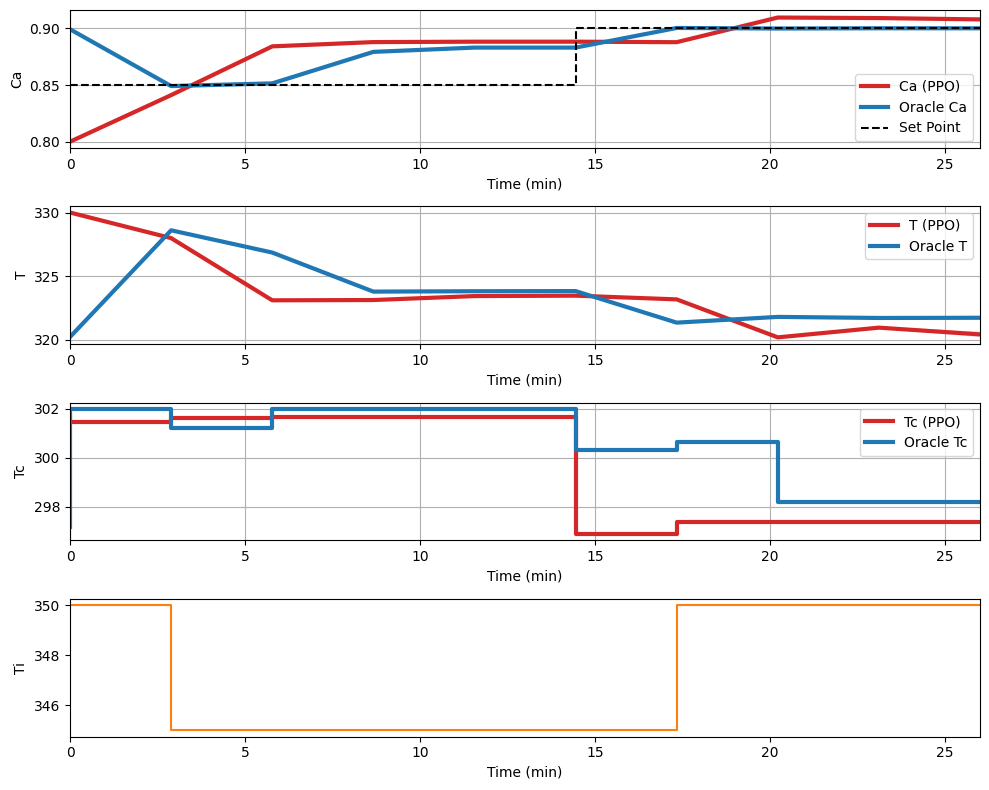

In [16]:
evaluator, data = env.plot_rollout({'PPO': PPO_policy}, oracle = True, reps = 2)